# Привет! Вы попали на код бота, который умеет определять настроение животного и генерировать картинку кота

In [1]:
import warnings
warnings.filterwarnings("ignore")

TOKEN = ''
available_commands = ['start', 'help', 'tell', 'generate']

## Модель классификации изображений

### Библиотеки для классификации

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import h5py
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import seaborn as sns
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten

sns.set_style('darkgrid')

### Готовим датасет для классификации

In [3]:
train_folder_path = '/Users/kseniashk/Downloads/dataset_with_cat/Master Folder/train'
valid_folder_path = '/Users/kseniashk/Downloads/dataset_with_cat/Master Folder/train'
test_folder_path = '/Users/kseniashk/Downloads/dataset_with_cat/Master Folder/train'
folder_path = '/Users/kseniashk/Downloads/dataset_with_cat/Master Folder/train'

filepaths = []
labels = []
folds = ['Angry', 'Other', 'Sad', 'Happy']

for fold in folds:
    foldpath = os.path.join(folder_path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [4]:
a = pd.Series(filepaths, name = 'Filepaths')
b = pd.Series(labels, name = 'Emotions')

df = pd.concat([a, b], axis= 1)
df.head()

Filepaths Emotions
0  /Users/kseniashk/Downloads/dataset_with_cat/Ma...    Angry
1  /Users/kseniashk/Downloads/dataset_with_cat/Ma...    Angry
2  /Users/kseniashk/Downloads/dataset_with_cat/Ma...    Angry
3  /Users/kseniashk/Downloads/dataset_with_cat/Ma...    Angry
4  /Users/kseniashk/Downloads/dataset_with_cat/Ma...    Angry

### Разделяем данные для обучения, валидации и теста

In [5]:
train_dataset, other_dataset = train_test_split(df,  train_size = 0.85, shuffle = True, random_state = 31)
valid_dataset, test_dataset = train_test_split(other_dataset,  train_size = 0.7, shuffle = True, random_state = 37)

### Генерация данных для обучения и валидации модели с использованием DataFrame

In [6]:
batch_size = 16
img_size = (200, 200)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
test_batch_size = max(sorted([len(test_dataset) // n for n in range(1, len(test_dataset) + 1) if len(test_dataset) % n == 0 and len(test_dataset) / n <= 80]))

def scalar(img):
    return img
    
imageDataGenerator = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=50,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=0.2,
    horizontal_flip=True, vertical_flip=True,
)

train_gen = imageDataGenerator.flow_from_dataframe(
    dataframe = train_dataset,
    x_col = 'Filepaths',
    y_col = 'Emotions',
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

valid_gen = imageDataGenerator.flow_from_dataframe(
    dataframe = valid_dataset,
    x_col = 'Filepaths',
    y_col = 'Emotions',
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen = imageDataGenerator.flow_from_dataframe(
    dataframe = test_dataset,
    x_col = 'Filepaths',
    y_col = 'Emotions',
    target_size = img_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = test_batch_size
)

Found 850 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Found 45 validated image filenames belonging to 4 classes.


### Сравним 3 предобученные модели, чтобы понять какая лучше

Я выбрала ResNet50, EfficientNetB5, InceptionV3. Объясню свой выбор:

Я сравниваю эти три модели для решения моей задачи классификации настроения животных, потому что они являются одними из самых популярных и эффективных предварительно обученных моделей для классификации изображений. Каждая из этих моделей имеет свои преимущества и особенности, и моя цель состоит в том, чтобы определить, какая из них лучше подходит для моей конкретной задачи, чтобы получить, как можно больший процент на тестовой выборке и на реальных тестах знакомых :).

ResNet50: Эта модель основана на архитектуре сверточной нейронной сети (CNN) с остаточными соединениями (residual connections), которая позволяет эффективно обучать глубокие сети, избегая проблемы исчезающих градиентов. ResNet50 состоит из 50 слоев.

EfficientNetB5: Эта модель является частью семейства EfficientNet, которое было разработано для масштабирования сверточных нейронных сетей с помощью комбинации глубины, ширины и разрешения изображения. EfficientNetB5 является самой крупной моделью в этом семействе.

InceptionV3: Эта модель основана на архитектуре Inception, которая сочетает в себе преимущества нескольких сверточных нейронных сетей. InceptionV3 состоит из множества модулей Inception, которые включают в себя сверточные, пулинговые и нормализационные слои.

## Cоздание модели с использованием предобученной модели ResNet50 и добавлением дополнительных слоев

In [7]:
img_size = (200, 200)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = ResNet50(include_top=False, weights ='imagenet', input_shape=img_shape)
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer=l2(0.1), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.build((None, 200, 200, 3))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,712,900 (189.64 MB)

 Trainable params: 25,924,484 (98.89 MB)

 Non-trainable params: 23,788,416 (90.75 MB)

### Компиляция модели

In [8]:
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy'])

### Обучение модели

In [9]:
batch_size = 16
history = model.fit(x = train_gen,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - categorical_accuracy: 0.3255 - loss: 18.9931 - val_categorical_accuracy: 0.4095 - val_loss: 20.2753
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - categorical_accuracy: 0.3869 - loss: 17.8444 - val_categorical_accuracy: 0.4667 - val_loss: 17.6671
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - categorical_accuracy: 0.4502 - loss: 16.6986 - val_categorical_accuracy: 0.5429 - val_loss: 15.9789
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - categorical_accuracy: 0.4847 - loss: 15.9695 - val_categorical_accuracy: 0.5333 - val_loss: 15.2802
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - categorical_accuracy: 0.5602 - loss: 14.9402 - val_categorical_accuracy: 0.4857 - val_loss: 14.8299
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - categorical_accuracy: 0.5263 - loss: 14.4013 - val_categorical_accuracy: 0.5905 - val_loss: 14.0410
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - categorical_acc

### Посмотрим графики, как обучалась наша модель

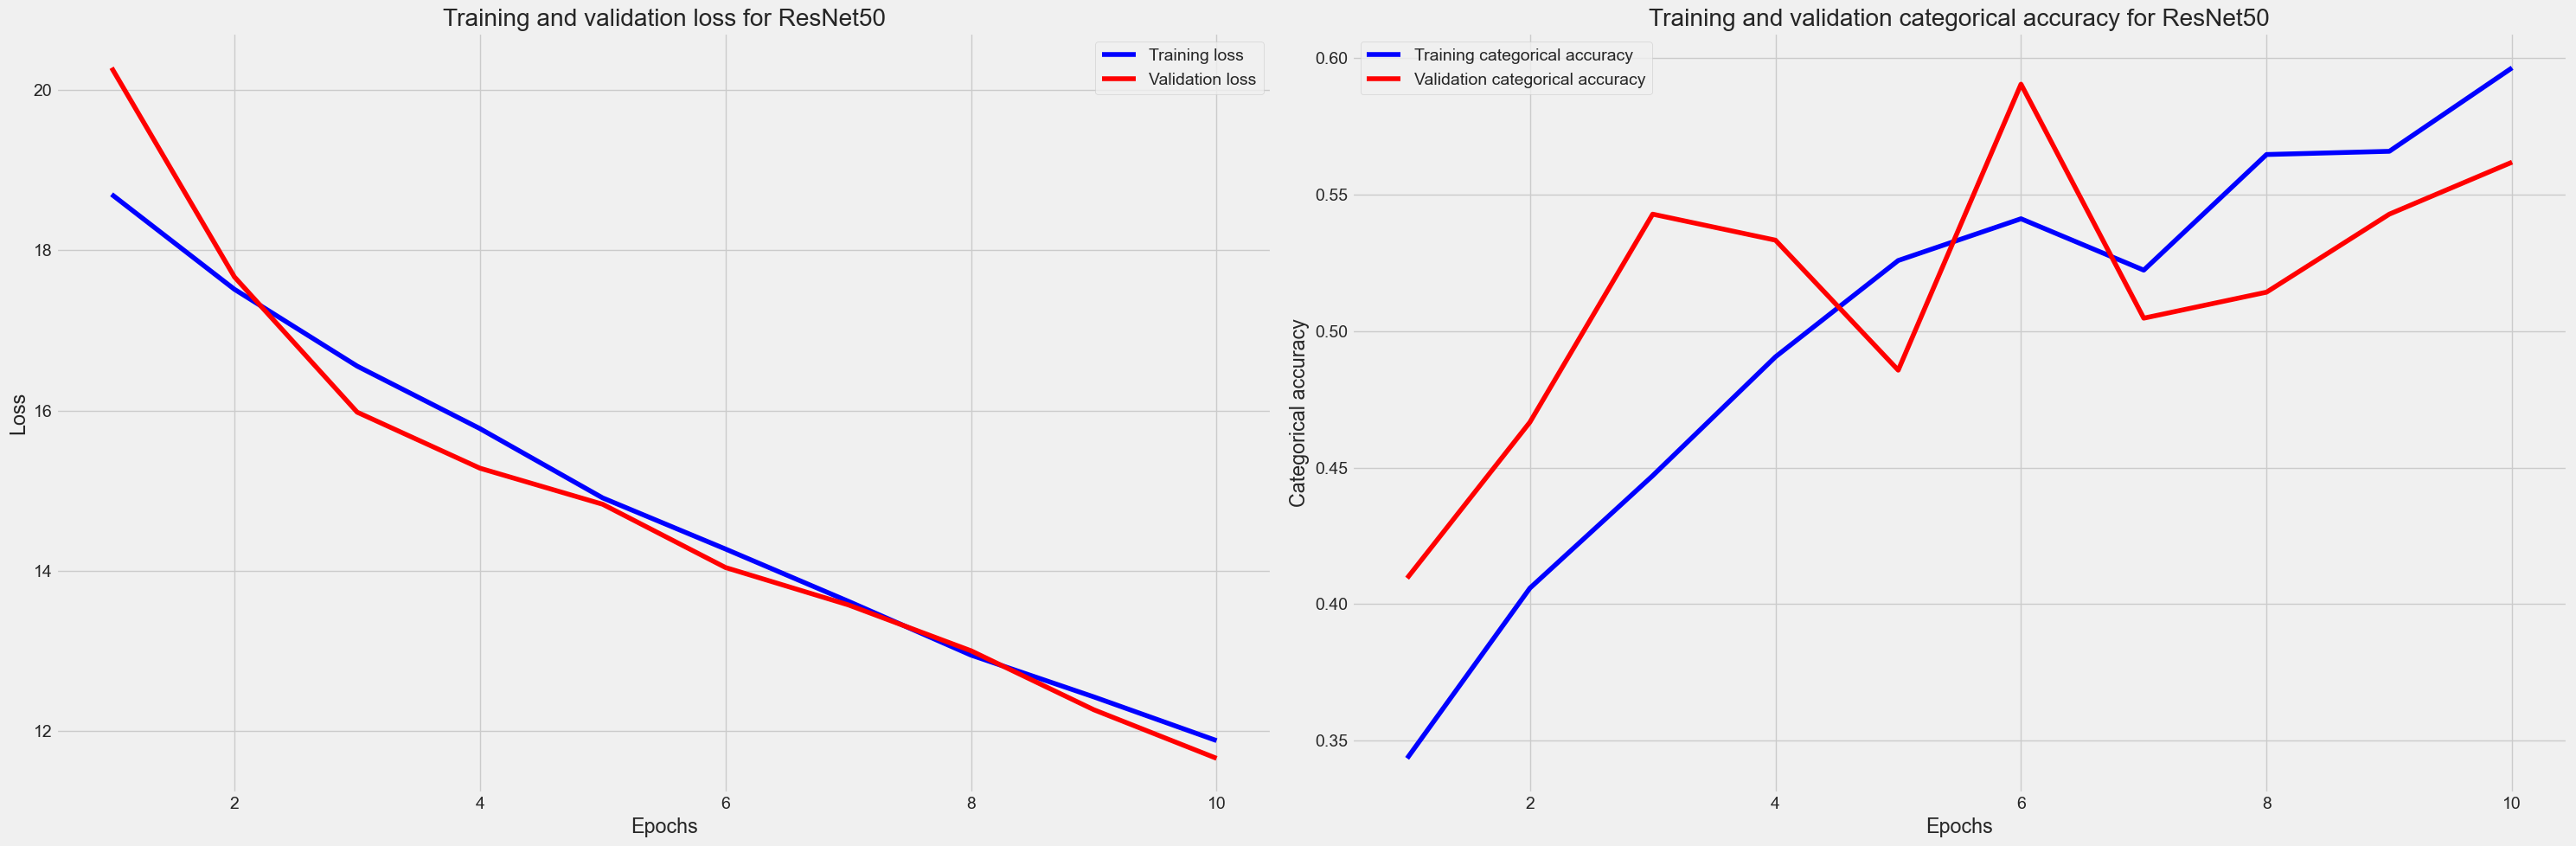

In [61]:
val_accuracy = history.history['val_categorical_accuracy']
val_loss = history.history['val_loss']
tr_accuracy = history.history['categorical_accuracy']
tr_loss = history.history['loss']
epochs = [i + 1 for i in range(len(tr_accuracy))]

plt.figure(figsize=(30, 10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_accuracy, 'b', label='Training categorical accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation categorical accuracy')
plt.title('Training and validation categorical accuracy for ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Проверяем качество модели на тестовых данных

In [11]:
test_batch_size = max(sorted([len(test_dataset) // n for n in range(1, len(test_dataset) + 1) if len(test_dataset)%n == 0 and len(test_dataset)/n <= 80]))
test_steps = len(test_dataset) // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - categorical_accuracy: 0.7500 - loss: 10.8957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - categorical_accuracy: 0.6875 - loss: 11.3696
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step - categorical_accuracy: 0.6667 - loss: 11.6163
Train Loss:  10.895696640014648
Train Accuracy:  0.75
--------------------
Test Loss:  11.616275787353516
Test Accuracy:  0.6666666865348816


### Удаляем модель

In [12]:
del model

## Cоздание модели с использованием предобученной модели EfficientNetB5 и добавлением дополнительных слоев

In [13]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4

base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape)
base_model.trainable = False

model2 = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer=l2(0.1),  activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model2.build((None, 200, 200, 3))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 7, 7, 2048)     │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,638,715 (208.43 MB)

 Trainable params: 25,924,484 (98.89 MB)

 Non-trainable params: 28,714,231 (109.54 MB)

### Компиляция модели

In [14]:
model2.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy'])

### Обучение модели

In [15]:
batch_size = 16
history2 = model2.fit(x = train_gen,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = True)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 542ms/step - categorical_accuracy: 0.3603 - loss: 19.4161 - val_categorical_accuracy: 0.5048 - val_loss: 17.4297
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 540ms/step - categorical_accuracy: 0.4274 - loss: 18.0650 - val_categorical_accuracy: 0.5429 - val_loss: 16.3792
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 537ms/step - categorical_accuracy: 0.4831 - loss: 17.1928 - val_categorical_accuracy: 0.5333 - val_loss: 15.8388
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 511ms/step - categorical_accuracy: 0.5189 - loss: 16.3455 - val_categorical_accuracy: 0.6000 - val_loss: 15.1663
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 515ms/step - categorical_accuracy: 0.5372 - loss: 15.4657 - val_categorical_accuracy: 0.5524 - val_loss: 14.4625
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 537ms/step - categorical_accuracy: 0.5350 - loss: 14.9406 - val_categorical_accuracy: 0.5714 - val_loss: 14.1320
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 524ms/step - categorical_acc

### Посмотрим графики, как обучалась наша модель

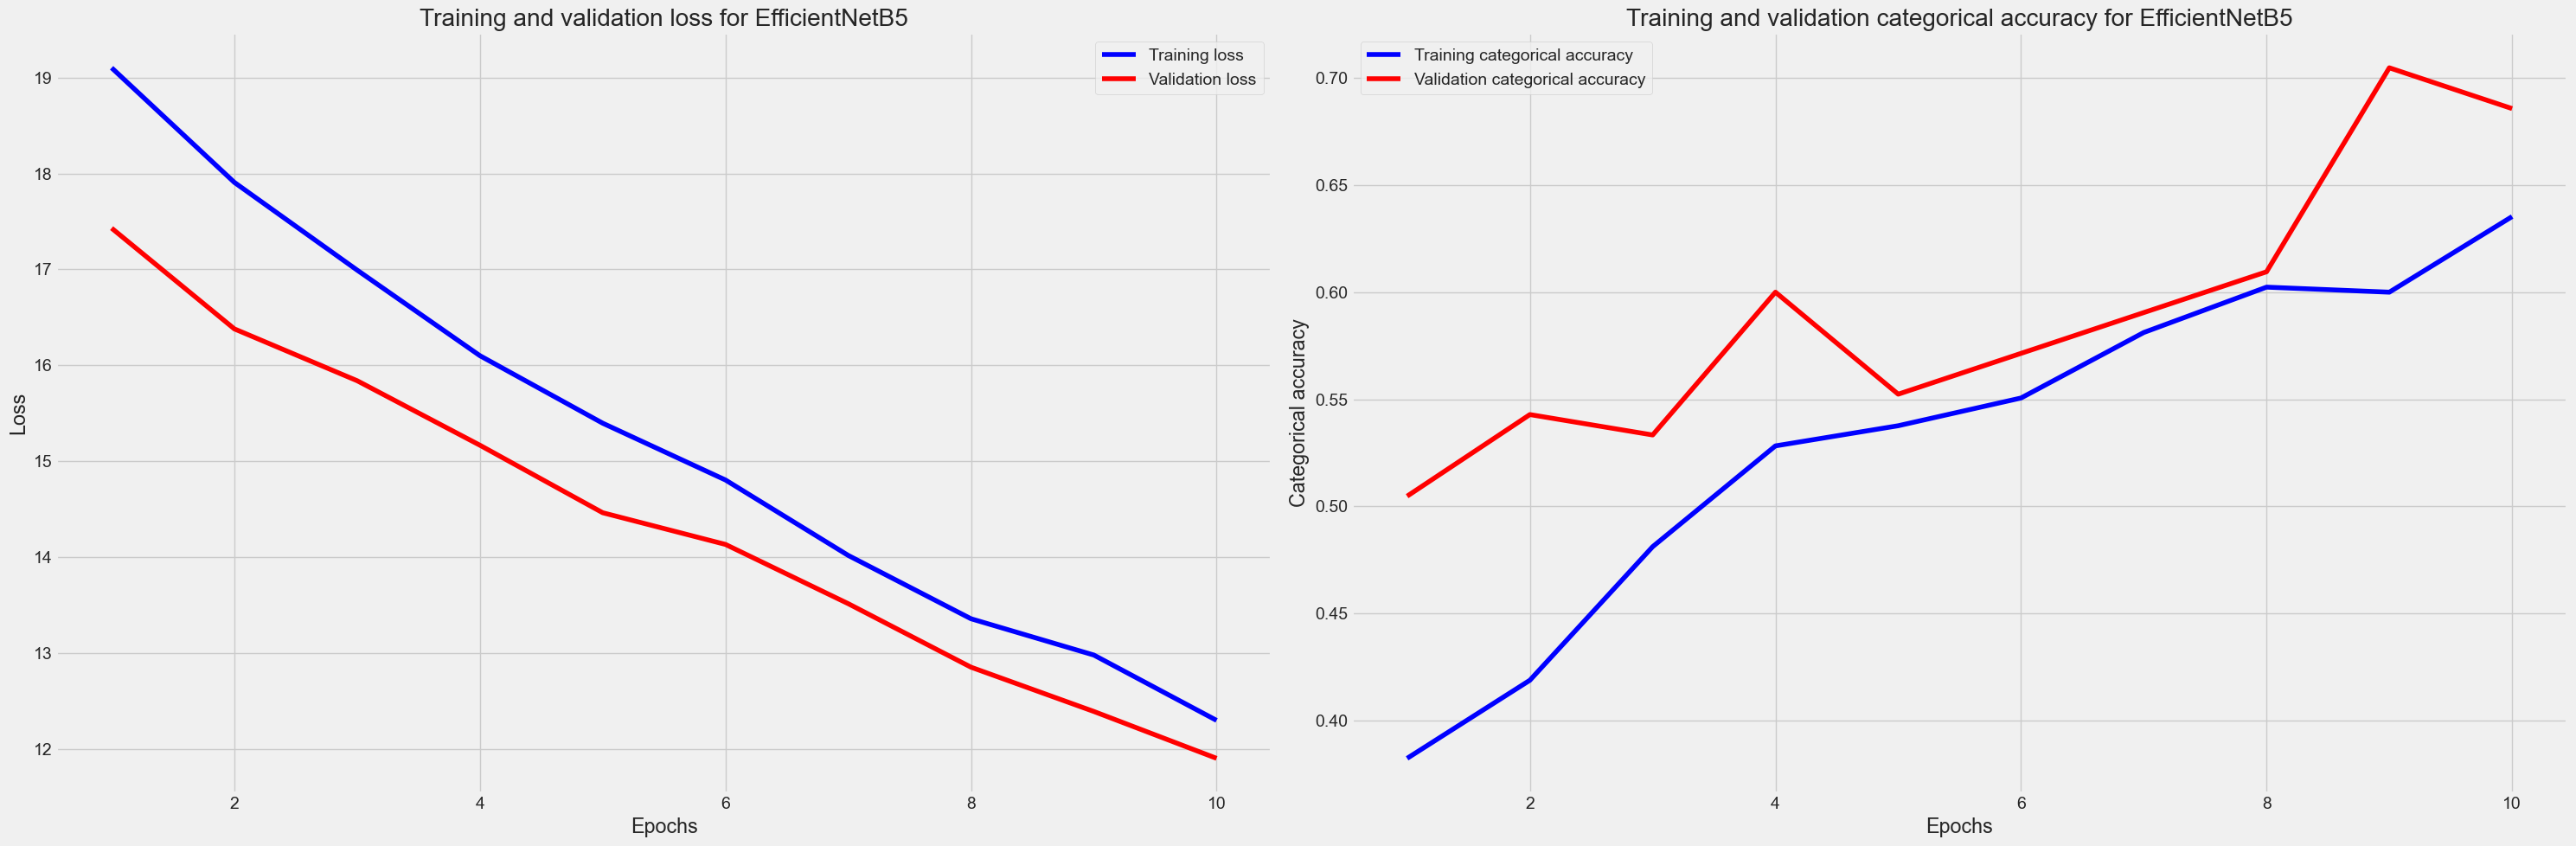

In [60]:
val_accuracy = history2.history['val_categorical_accuracy']
val_loss = history2.history['val_loss']
tr_accuracy = history2.history['categorical_accuracy']
tr_loss = history2.history['loss']
epochs = [i + 1 for i in range(len(tr_accuracy))]

plt.figure(figsize=(30, 10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for EfficientNetB5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_accuracy, 'b', label='Training categorical accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation categorical accuracy')
plt.title('Training and validation categorical accuracy for EfficientNetB5')
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Проверяем качество модели на тестовых данных

In [17]:
test_batch_size = max(sorted([len(test_dataset) // n for n in range(1, len(test_dataset) + 1) if len(test_dataset)%n == 0 and len(test_dataset)/n <= 80]))
test_steps = len(test_dataset) // test_batch_size

train_score = model2.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model2.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model2.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - categorical_accuracy: 0.6875 - loss: 11.8273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - categorical_accuracy: 0.6875 - loss: 11.9946
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 0.7111 - loss: 11.6536
Train Loss:  11.827335357666016
Train Accuracy:  0.6875
--------------------
Test Loss:  11.65356159210205
Test Accuracy:  0.7111111283302307


### Удаляем модель

In [18]:
del model2

## Cоздание модели с использованием предобученной модели InceptionV3 и добавлением дополнительных слоев

In [23]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)
base_model.trainable = False

model3 = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer=l2(0.1),  activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model3.build((None, 200, 200, 3))
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 4, 4, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_286         │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,356,132 (115.80 MB)

 Trainable params: 8,487,812 (32.38 MB)

 Non-trainable params: 21,868,320 (83.42 MB)

### Компиляция модели

In [24]:
model3.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy'])

### Обучение модели

In [25]:
batch_size = 16
history3 = model3.fit(x = train_gen,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - categorical_accuracy: 0.2343 - loss: 19.5294 - val_categorical_accuracy: 0.1905 - val_loss: 19.4079
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - categorical_accuracy: 0.2964 - loss: 18.2215 - val_categorical_accuracy: 0.2571 - val_loss: 18.0989
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - categorical_accuracy: 0.3063 - loss: 17.1267 - val_categorical_accuracy: 0.2857 - val_loss: 16.9714
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - categorical_accuracy: 0.3273 - loss: 16.4117 - val_categorical_accuracy: 0.2762 - val_loss: 15.4383
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - categorical_accuracy: 0.3199 - loss: 15.4548 - val_categorical_accuracy: 0.3619 - val_loss: 14.6845
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - categorical_accuracy: 0.3358 - loss: 14.5445 - val_categorical_accuracy: 0.3429 - val_loss: 13.8863
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - categorical_acc

### Посмотрим графики, как обучалась наша модель

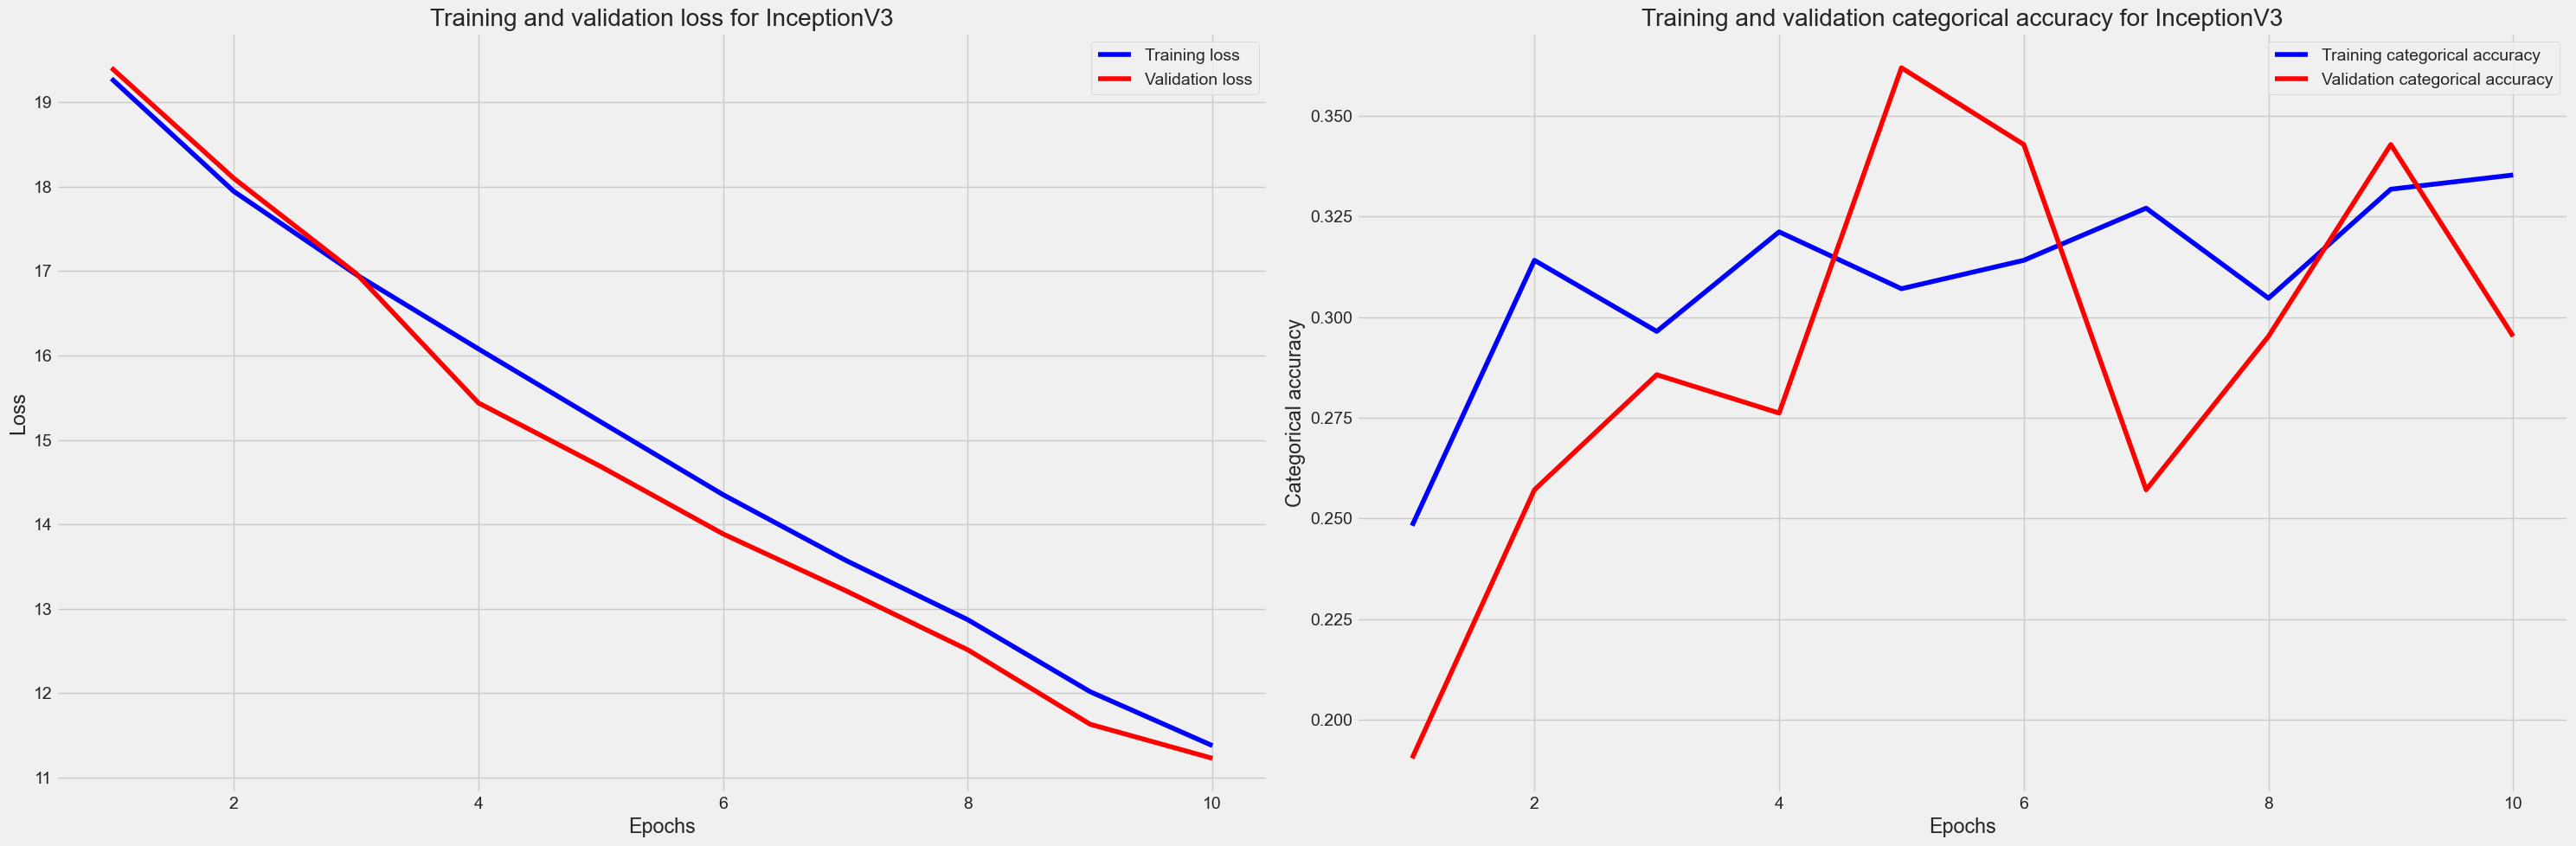

In [58]:
val_accuracy = history3.history['val_categorical_accuracy']
val_loss = history3.history['val_loss']
tr_accuracy = history3.history['categorical_accuracy']
tr_loss = history3.history['loss']
epochs = [i + 1 for i in range(len(tr_accuracy))]

plt.figure(figsize=(30, 10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss for InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_accuracy, 'b', label='Training categorical accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation categorical accuracy')
plt.title('Training and validation categorical accuracy for InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Проверяем качество модели на тестовых данных

In [29]:
test_batch_size = max(sorted([len(test_dataset) // n for n in range(1, len(test_dataset) + 1) if len(test_dataset)%n == 0 and len(test_dataset)/n <= 80]))
test_steps = len(test_dataset) // test_batch_size

train_score = model3.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model3.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model3.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - categorical_accuracy: 0.3750 - loss: 10.8803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - categorical_accuracy: 0.3125 - loss: 11.6331
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - categorical_accuracy: 0.4000 - loss: 10.7455
Train Loss:  10.880308151245117
Train Accuracy:  0.375
--------------------
Test Loss:  10.74553108215332
Test Accuracy:  0.4000000059604645


### Удаляем модель

In [30]:
del model3

### Делаем вывод, что предобученная модель EfficientNetB5 лучшая для нашей задачи, потому что у нее лучшие графики loss and accuracy и лучший процент на тестовой выборке(71.1%!)

### Создаем снова модель, которая работает на основе предобученной модели EfficientNetB5, компилируем и обучаем.

In [31]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4

base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape)
base_model.trainable = False

the_best_model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer=l2(0.1),  activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

the_best_model.build((None, 200, 200, 3))

the_best_model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy'])

batch_size = 16
best_history = the_best_model.fit(x = train_gen,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 553ms/step - categorical_accuracy: 0.3484 - loss: 19.6907 - val_categorical_accuracy: 0.5143 - val_loss: 17.6412
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 531ms/step - categorical_accuracy: 0.4594 - loss: 18.3216 - val_categorical_accuracy: 0.4190 - val_loss: 17.1383
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - categorical_accuracy: 0.4248 - loss: 17.6424 - val_categorical_accuracy: 0.5143 - val_loss: 16.2811
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 521ms/step - categorical_accuracy: 0.5456 - loss: 16.6595 - val_categorical_accuracy: 0.5429 - val_loss: 15.7970
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 514ms/step - categorical_accuracy: 0.5493 - loss: 16.0287 - val_categorical_accuracy: 0.5429 - val_loss: 15.0179
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 513ms/step - categorical_accuracy: 0.5233 - loss: 15.2500 - val_categorical_accuracy: 0.5429 - val_loss: 14.5562
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 525ms/step - categori

### Проверяем как обучалась наша лучшая модель на 100 эпохах и какие теперь результаты на тестовой выборке.

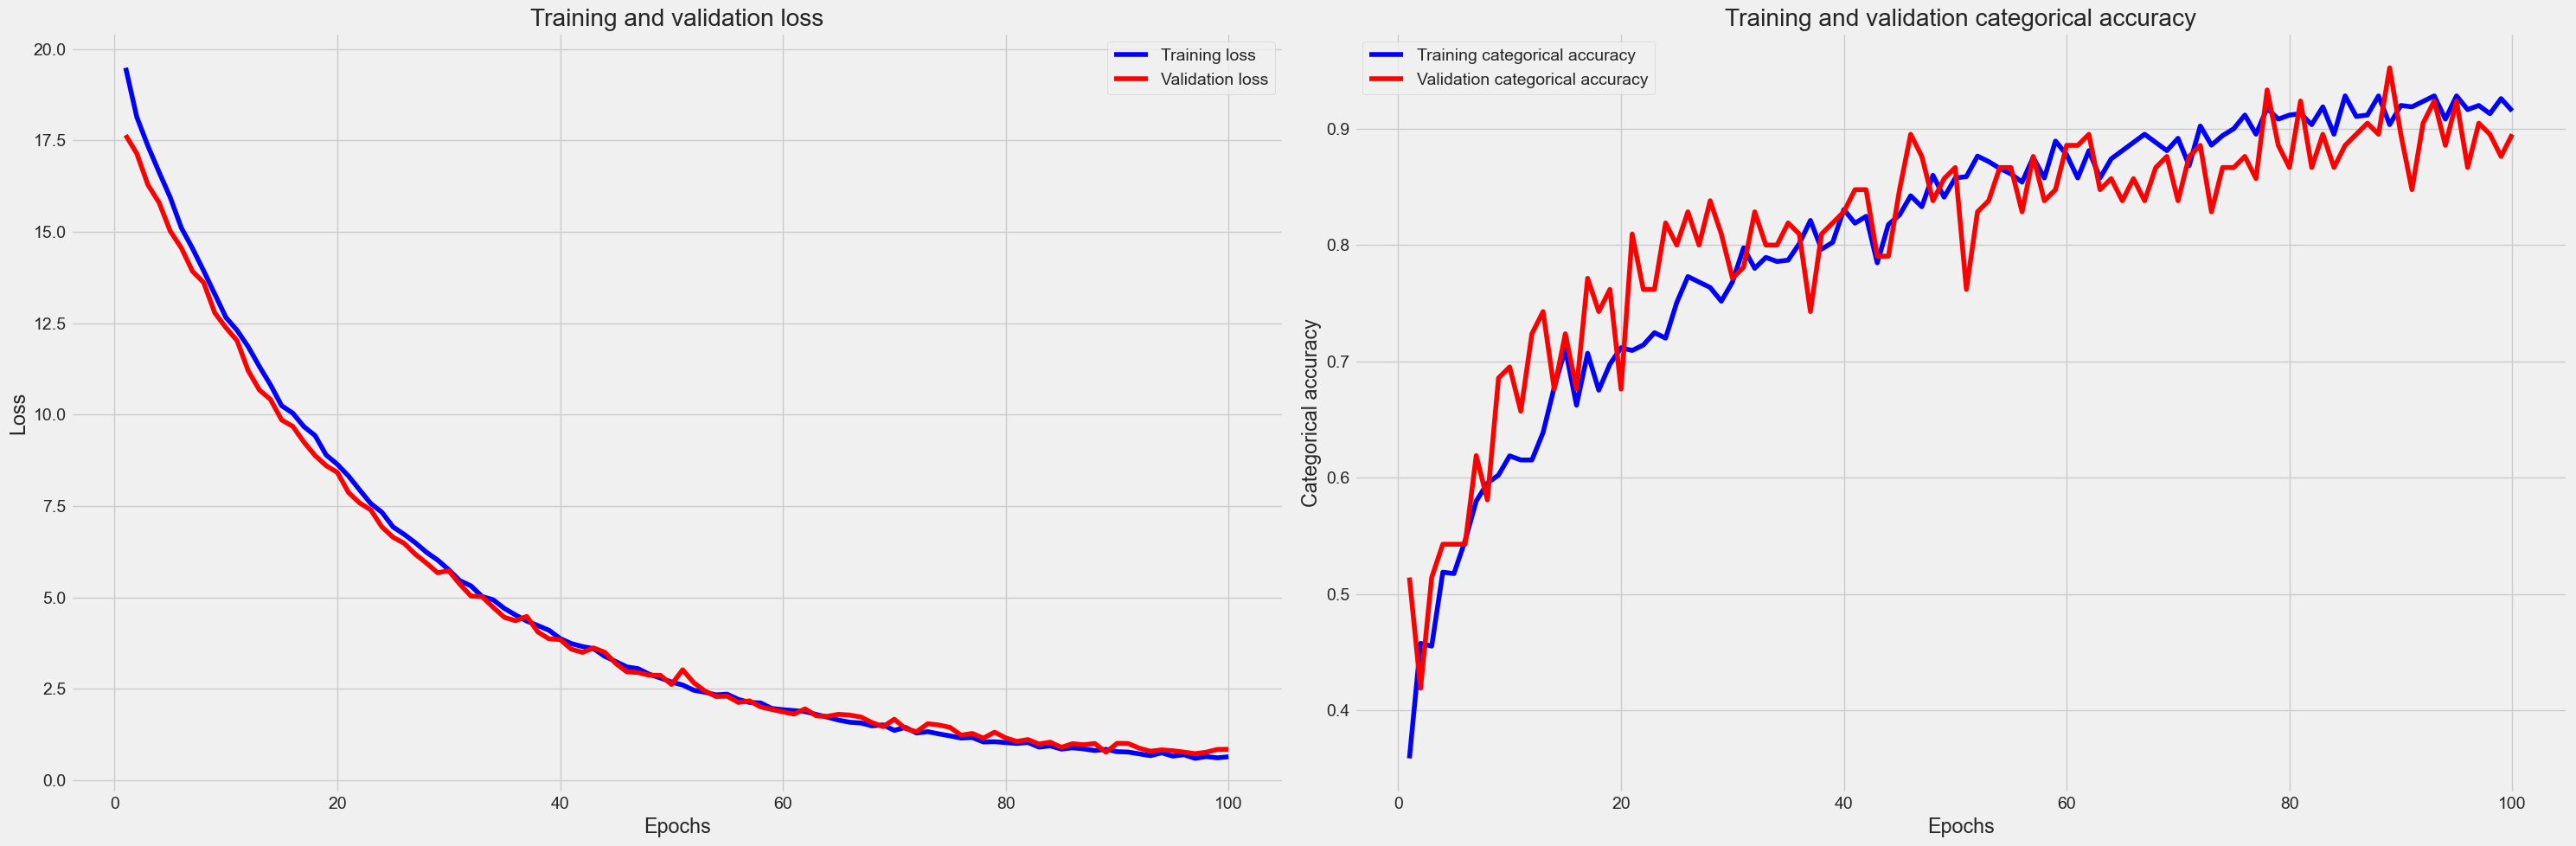

In [59]:
val_accuracy = best_history.history['val_categorical_accuracy']
val_loss = best_history.history['val_loss']
tr_accuracy = best_history.history['categorical_accuracy']
tr_loss = best_history.history['loss']
epochs = [i + 1 for i in range(len(tr_accuracy))]

plt.figure(figsize=(30, 10))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_accuracy, 'b', label='Training categorical accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation categorical accuracy')
plt.title('Training and validation categorical accuracy')
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Проверяем качество модели на тестовых данных

In [49]:
test_batch_size = max(sorted([len(test_dataset) // n for n in range(1, len(test_dataset) + 1) if len(test_dataset)%n == 0 and len(test_dataset)/n <= 80]))
test_steps = len(test_dataset) // test_batch_size

train_score = the_best_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = the_best_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = the_best_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - categorical_accuracy: 0.8750 - loss: 0.6017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - categorical_accuracy: 0.8750 - loss: 1.0434
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - categorical_accuracy: 0.9333 - loss: 0.5459
Train Loss:  0.6017083525657654
Train Accuracy:  0.875
--------------------
Test Loss:  0.5459042191505432
Test Accuracy:  0.9333333373069763


### Сохраняем веса, чтобы не обучать модель на 100+ эпохах после каждого перезапуска:)

In [34]:
the_best_model.save_weights('model.weights.h5')

### Создаем новую модель, в которую загрузим веса сохраненной модели

In [35]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4

base_model = EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape)
base_model.trainable = False

model_res = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer=l2(0.1),  activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model_res.build((None, 200, 200, 3))
model_res.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 7, 7, 2048)     │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_288         │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,638,715 (208.43 MB)

 Trainable params: 25,924,484 (98.89 MB)

 Non-trainable params: 28,714,231 (109.54 MB)

### Выгружаем веса

In [36]:
model_res.load_weights('model_weights.h5')

### Создаем функцию, которая возращает какое настроение у животного

In [37]:
def predict_and_display_only_name(image_path, model):
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label
    
class_labels = ['Angry', 'Other', 'Sad', 'Happy']

In [38]:
image_path_to_test = '/Users/kseniashk/Downloads/кот.jpg'
predict_and_display_only_name(image_path_to_test, model_res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'Angry'

## Модель генерации котов

### Библиотеки для генерации

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

### Определение некоторых гиперпараметров для обучения генеративной модели

In [77]:
batch_size = 128
lr = 0.0002
image_size = 64
sz = 128

### Определение архитектуры дискриминатора для генеративной модели

In [78]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

### Определение архитектуры генератора для генеративной модели

In [79]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(sz,)),
        layers.Reshape((1, 1, sz)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

### Создание экземпляра дискриминатора на основе архитектуры

In [80]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_287 (Conv2D)             │ (None, 32, 32, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_297         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_288 (Conv2D)             │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_298         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_289 (Conv2D)             │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_299         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_290 (Conv2D)             │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_300         │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_291 (Conv2D)             │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_284 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,616 (10.56 MB)

 Trainable params: 2,765,696 (10.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Создание экземпляра генератора на основе архитектуры

In [81]:
generator = build_generator()
generator.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 4, 4, 512)      │     1,048,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_301         │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_302         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_303         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_304         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 3)      │         3,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_285 (Activation)     │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,808,000 (14.53 MB)

 Trainable params: 3,806,080 (14.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Создание экземпляра функции потерь бинарного кросс-энтропии

In [82]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

### Определение функции потерь для дискриминатора и генератора

In [83]:
def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Создание двух экземпляров оптимизатора Adam для обучения генератора и дискриминатора 

In [84]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.5)

### Определение функции шага обучения модели

In [85]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, sz])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Путь до папки с датасетом

In [88]:
data_dir = '/Users/kseniashk/Downloads/cats_faces/cats'

### Создание набора данных для обучения генеративной модели

In [89]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    image_size=(image_size, image_size), 
    batch_size=batch_size, 
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

Found 15747 files.


### Обучение генеративной модели

In [91]:
epochs = 50
cnt1 = 1
cnt2 = 9
summepochs = 0

for k in range(1,21):
    for epoch in range(1, epochs + 1):
        summepochs += 1
        for image_batch in train_dataset:
            train_step(image_batch)
    generator.save_weights('generator_'+str(summepochs)+'.weights.h5')


KeyboardInterrupt



### Загружаем веса моделей

In [143]:
generators = [generator] * ((1000 - 400) // 50 + 1)
for i in range(400, 1001, 50):
    generators[i // 50 - 8].load_weights('/Users/kseniashk/weights/generator_'+str(i)+'.weights.h5')

### Выводим примеры изображений на всех моделях

400


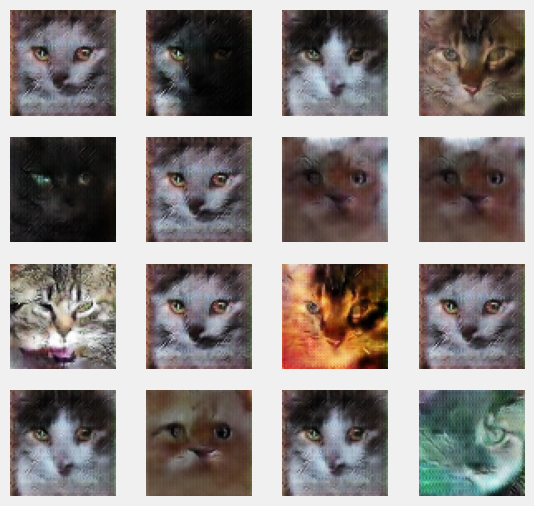

450


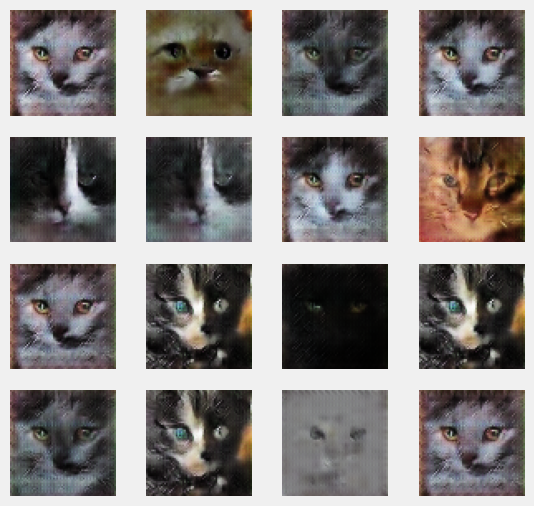

500


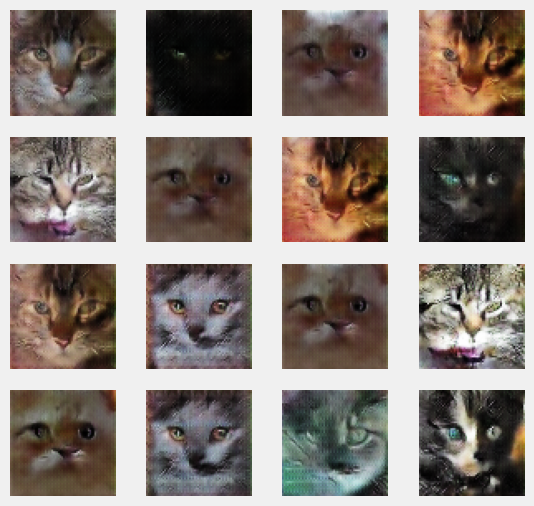

550


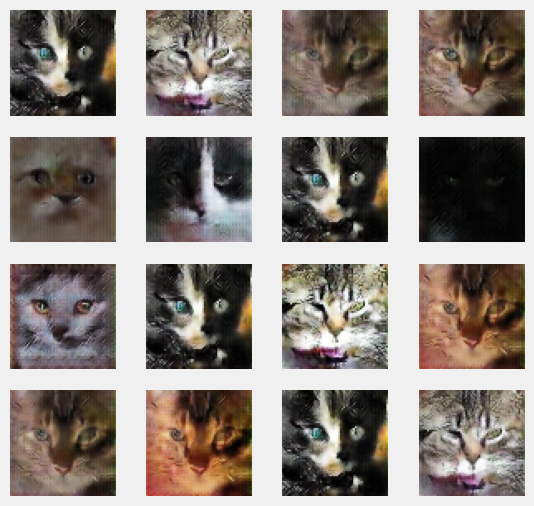

600


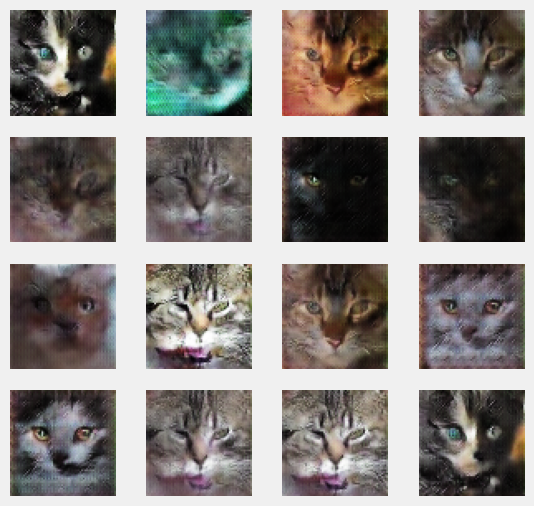

650


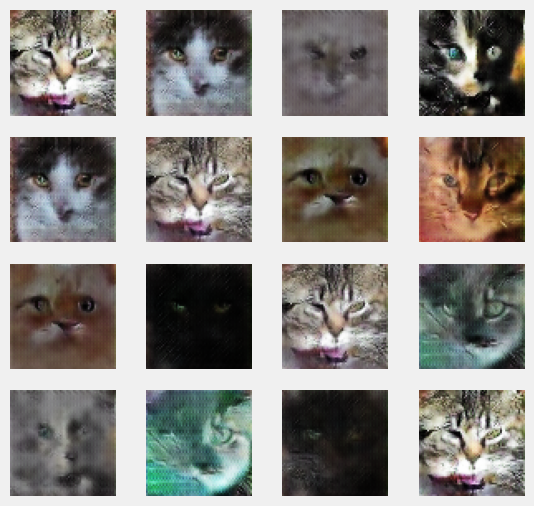

700


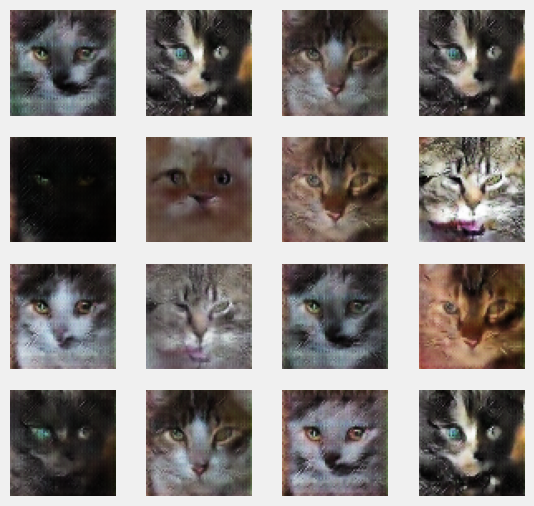

750


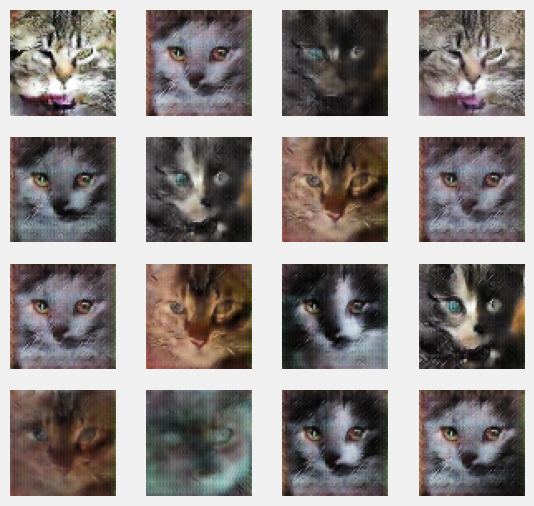

800


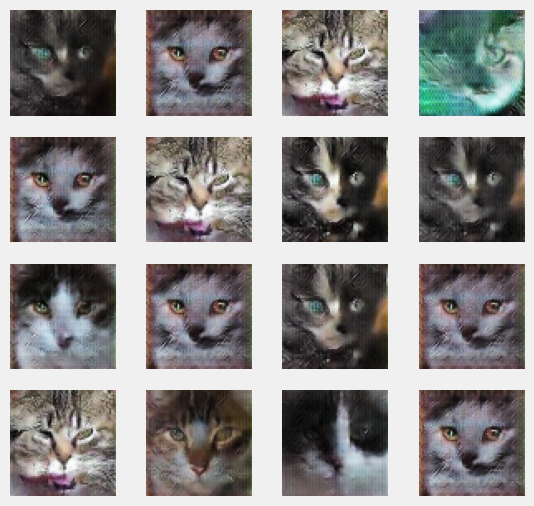

850


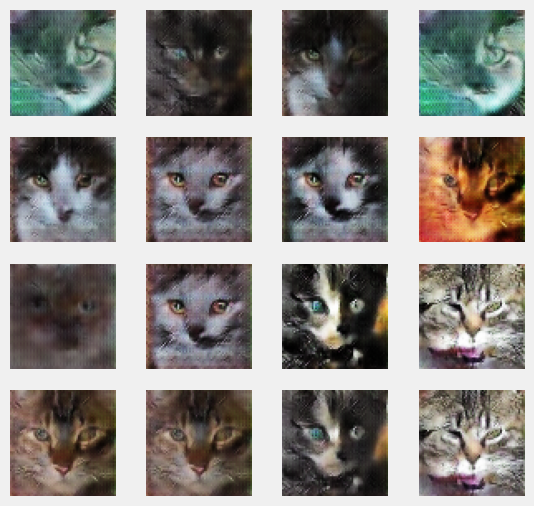

900


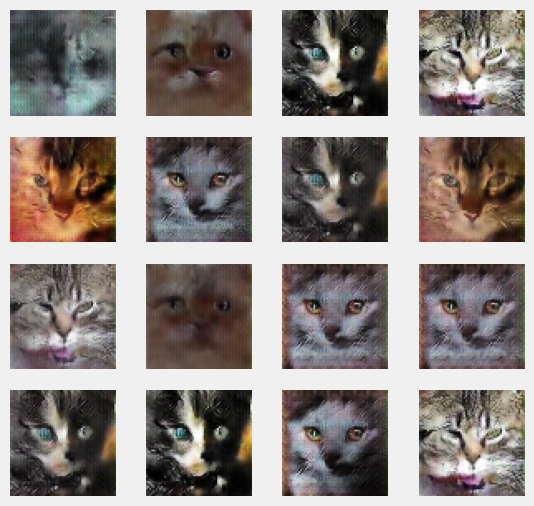

950


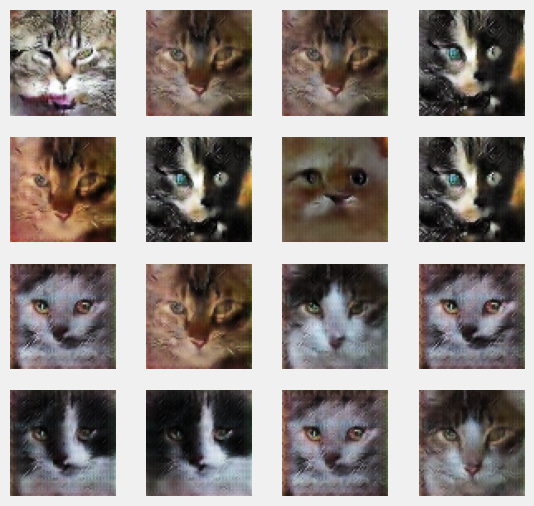

1000


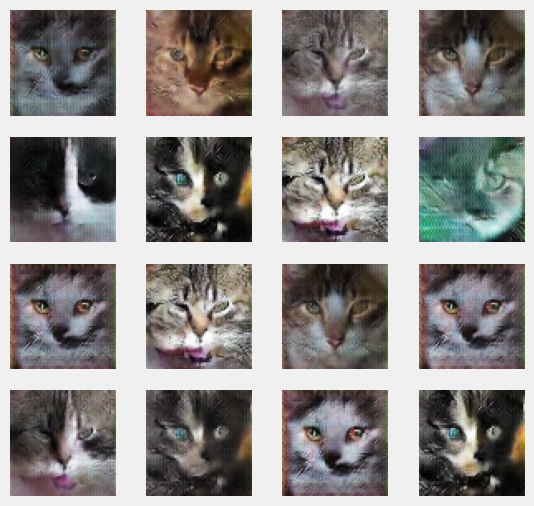

In [144]:
for j in range(len(generators)):
    print(400 + 50 * j)
    cnt = 16
    noise = tf.random.normal([cnt, sz])
    imgs = generators[j](noise)
    imgs = 0.5 * imgs + 0.5
    imgs = np.clip(imgs, 0, 1)
    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(cnt):
        axs[i // 4, i % 4].imshow(imgs[i])
        axs[i // 4, i % 4].axis('off')
    plt.show()

# Сам бот!

### Библиотеки для бота

In [145]:
import telebot
from PIL import Image
import io
import random

### Определение основных функций для бота

In [147]:
bot = telebot.TeleBot(TOKEN)

@bot.message_handler(commands=['help'])
def help_command(message):
    help_text = 'List of commands :\n' \
                '/start - get started with the bot!\n' \
                '/help - show list of commands\n' \
                '/tell - send a photo of the animal to determine its mood(can only show happy/sad/angry/other)\n' \
                '/generate - generate a random cat image\n' \
                'If you need more help, you can write to the creator of this bot @KseniiaShk'
    bot.send_message(message.chat.id, help_text)

@bot.message_handler(commands=['start'])
def start_command(message):
    start_text = 'Welcome! I hope you like my bot'
    bot.send_message(message.chat.id, start_text)
    help_command(message)
    
@bot.message_handler(commands=['tell'])
def tell_command(message):
    bot.send_message(message.chat.id, 'Send me a photo of your animal to determine its mood (it is advisable to send only the face to improve quality)')
    bot.register_next_step_handler(message, process_cat_image)
    
def process_cat_image(message):
    if message.text == '/start' or message.text == '/start@cats_emotions_bot':
        start_command(message)
        return
    elif message.text == '/help' or message.text == '/help@cats_emotions_bot':
        help_command(message)
        return
    elif message.text == '/generate' or message.text == '/generate@cats_emotions_bot':
        generate_command(message)
        return

    if message.content_type != 'photo':
        bot.send_message(message.chat.id, 'Please send me the picture')
        bot.register_next_step_handler(message, process_cat_image)
        return

    file_info = bot.get_file(message.photo[len(message.photo) - 1].file_id)
    downloaded_file = bot.download_file(file_info.file_path)

    file_extension = os.path.splitext(file_info.file_path)[1]

    with open('temp_animal_image.jpg', 'wb') as new_file:
        new_file.write(downloaded_file)

    bot.send_message(message.chat.id, "I got a picture of an animal! I'll determine his mood...")

    cat_mood = predict_and_display_only_name('temp_animal_image.jpg', model_res)
    bot.send_message(message.chat.id, f"Animal's mood: {cat_mood}")


@bot.message_handler(commands=['generate'])
def generate_command(message):
    random_number = random.randint(0, len(generators) - 1)
    bot.send_message(message.chat.id, "I have received your request. Now I am creating the perfect cat for you!")
    noise = tf.random.normal([1, sz])
    imgs = generators[random_number](noise)
    imgs = 0.5 * imgs + 0.5
    imgs = np.clip(imgs, 0, 1)
    img = Image.fromarray((imgs[0] * 255).astype(np.uint8))
    img_bytes = io.BytesIO()
    img.save(img_bytes, format='JPEG')
    img_bytes.seek(0)
    bot.send_photo(message.chat.id, photo=img_bytes)

@bot.message_handler(func=lambda message: True)
def unknown_command(message):
    bot.send_message(message.chat.id, 'There is no such command')

bot.polling(none_stop=True)